# Creating and Interpreting Segmentation Maps for Image Analysis

In computer vision, segmentation is not just a tool but a lens that reveals the finer details. Unlike bounding boxes that merely surround objects, segmentation maps delve deeper, offering pixel-level granularity to capture the subtleties that elevate image analysis.

In this notebook, we’ll journey through the transformative power of segmentation maps, focusing on their applications in image analysis. Using [**FiftyOne**](https://docs.voxel51.com/getting_started/install.html) and the **KITTI dataset**, we’ll explore practical techniques to create, interpret, and optimize segmentation maps for real-world use cases.

### What You’ll Learn:

1. **What Are Segmentation Maps?** Uncover the basics of segmentation, its types, and the scenarios where each technique shines.
2. **Visualizing and Interpreting Segmentation Maps with FiftyOne:** Dive into FiftyOne’s powerful visualization tools to explore segmented scenes and extract actionable insights.
3. **Creating High-Quality Segmentation Maps:** Master the art of generating precise segmentation maps through practical data annotation and augmentation strategies, leveraging FiftyOne’s capabilities.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import fiftyone as fo
import torch
from fiftyone import zoo as foz
import matplotlib.pyplot as plt
from fiftyone import ViewField as F


## Setup

### Step 1: Create a Virtual Environment

Before installing any libraries, it's a good practice to isolate your project dependencies by creating a virtual environment 

 `python3 -m venv kitti-env`

### Step 2: Install Necessary Libraries

1. **Install FiftyOne** 

    `pip install fiftyone`

2. **Install PyTorch**

    `pip install torch torchvision torchaudio`

### Step 3: Verify Installations


In [ ]:
# Verify FiftyOne
print(f"FiftyOne version: {fo.__version__}")

# Verify PyTorch
print(f"PyTorch version: {torch.__version__}")

## KITTI Data Loading

Loading KITTI dataset using FiftyOne [Dataset Zoo](https://docs.voxel51.com/dataset_zoo/datasets.html#kitti). The KITTI dataset provides left-camera images and 2D object detections, ideal for autonomous driving tasks.

The training split contains 7,481 annotated images, and the test split contains 7,518 unlabeled images.

In [2]:
kitti_data = foz.load_zoo_dataset("kitti",
                                split="train",
                                )

Split 'train' already downloaded
Loading existing dataset 'kitti-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Metadata Information

In [3]:
kitti_data

Name:        kitti-train
Media type:  image
Num samples: 7481
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


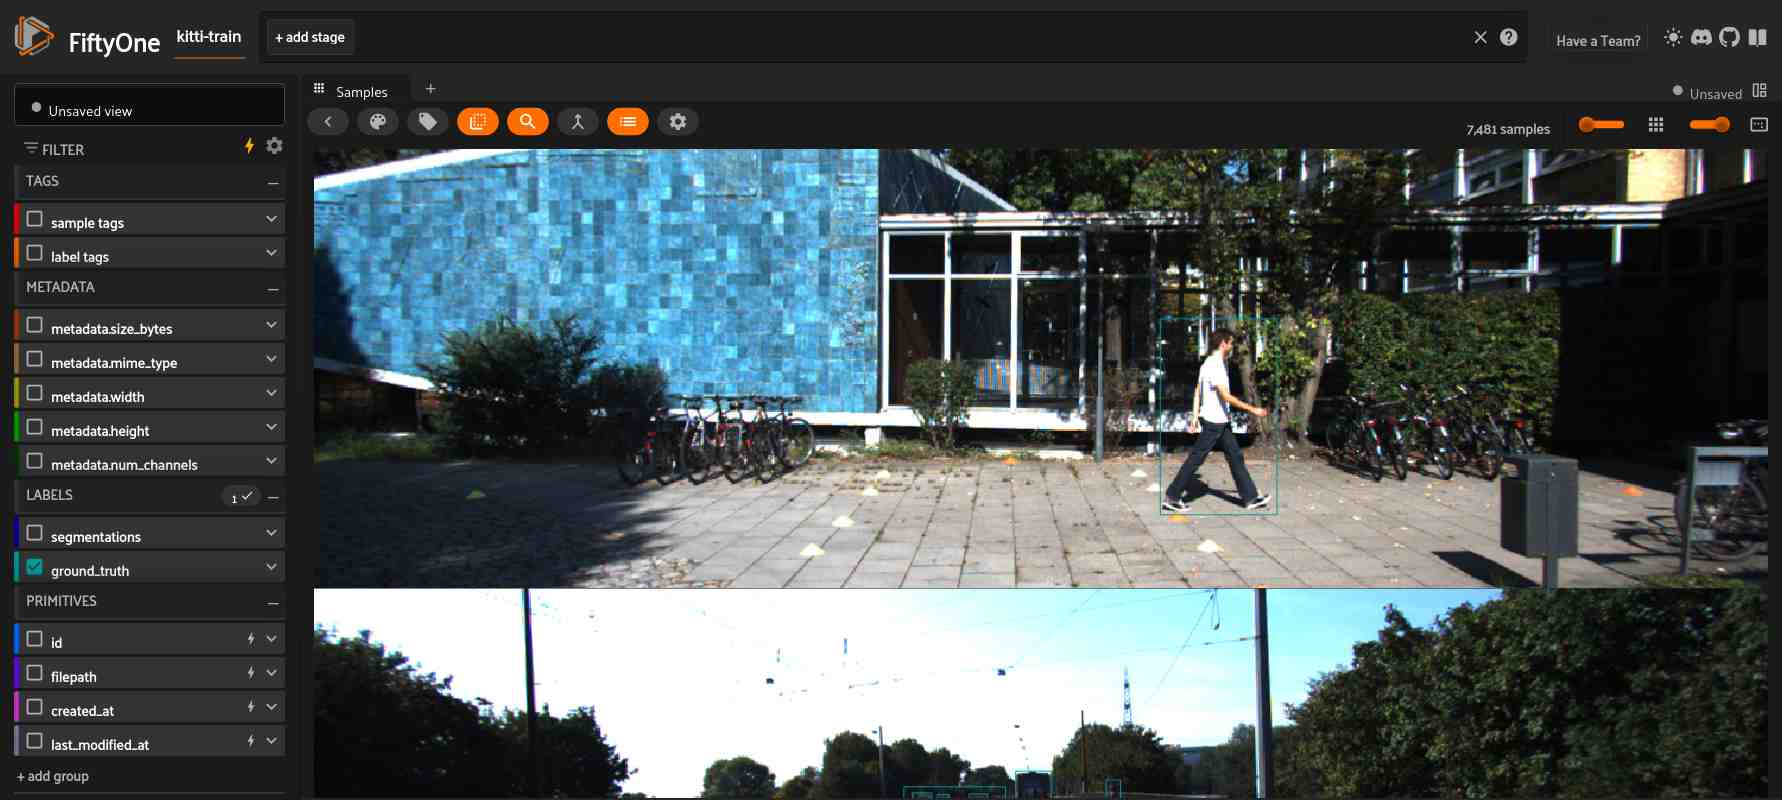

In [4]:
session = fo.launch_app(kitti_data)

In [5]:
session.freeze()

### Getting to know more about KITTI data 

The following graph tells us that there are more cars classes/objects in the dataset which is good and second highest is the "dontCare" class which I assume is extra unlabeled stuff. So ignoring that, secong highest class is the pedestrian class.

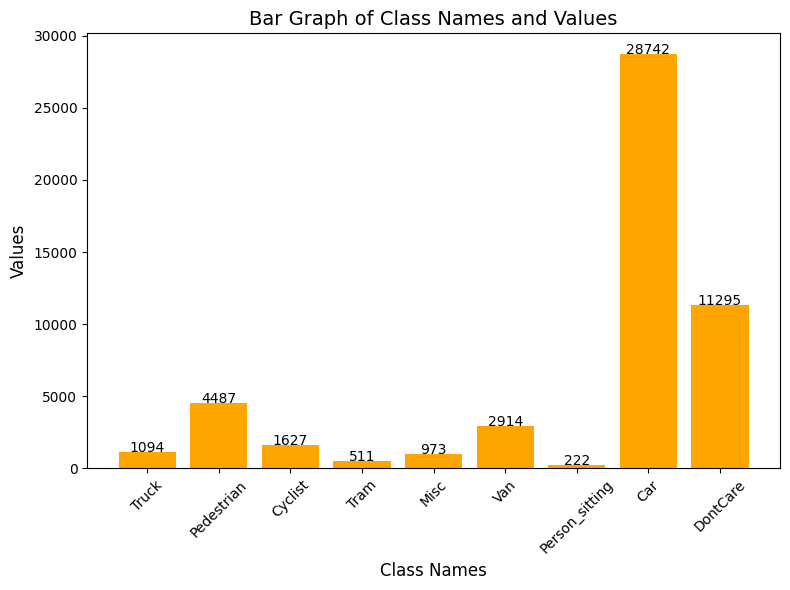

In [8]:
count_obj = kitti_data.count_values("ground_truth.detections.label")

class_names = count_obj.keys()
values = count_obj.values()

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, values,color='orange')

# Add labels and title
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Bar Graph of Class Names and Values', fontsize=14)
plt.xticks(rotation=45)
# Show value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()

### **Using FiftyOne ViewField for Filtering and Analysis**

To analyze only images containing `van`, we can filter the dataset based on the label. 

This is useful when we want to focus specifically on a particular class (e.g., van detection), helping us isolate images that contain this object. Once the subset is created, we can use it for further analysis or training specific to that class.

In [6]:
van_frames = kitti_data.filter_labels('ground_truth', 
                     (F('label') == "Van")
                     )
van_frames

Dataset:     kitti-train
Media type:  image
Num samples: 2145
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$eq': ['$$this.label', 'Van']}, only_matches=True, trajectories=False)


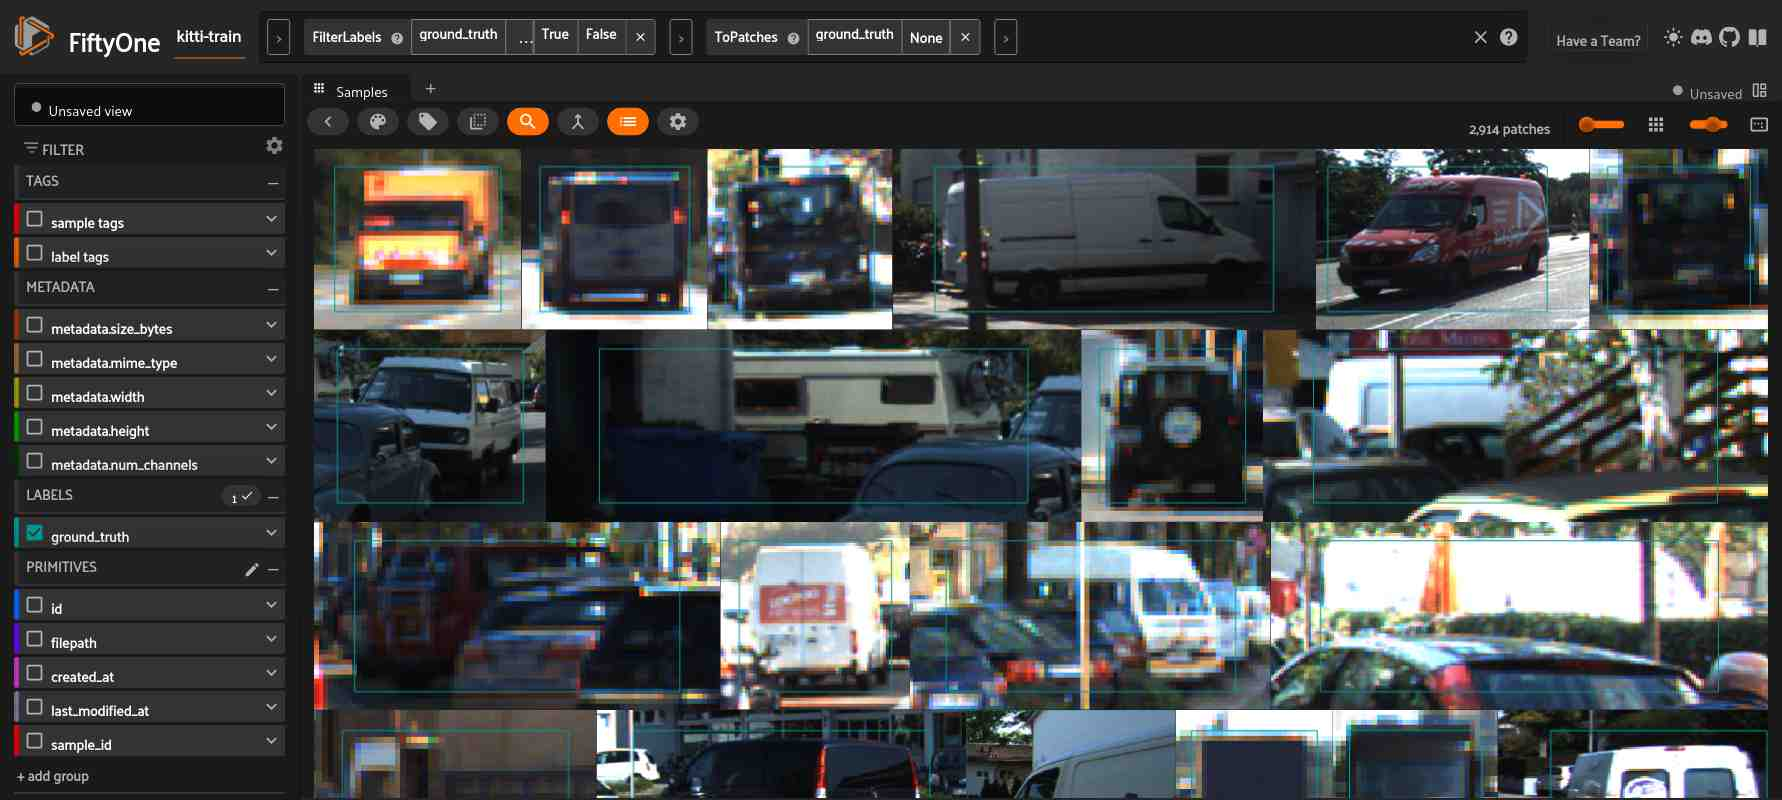

In [7]:
session.view = van_frames

In [8]:
session.freeze()

### **Running Predictions with SAM**

Applying **SAM (Segment Anything Model)** to generate segmentation masks from FiftyOne [Model Zoo](https://docs.voxel51.com/model_zoo/index.html), make sure to install the necessary libraries needed to run SAM. 

To load SAM, you need to install transformers and segment-anything - [SAM](https://github.com/facebookresearch/segment-anything/tree/main)

In [21]:
model = foz.load_zoo_model("segment-anything-vitb-torch")

## Running Predictions

    - Select 500 random images to run predictions on a manageable subset.
    - Save results in the `label_field` as masks.

This will take around 3-4 minutes. Unlike other models, SAM allows location-specific segmentation. This approach avoids clutter by running segmentation only within specified bounding box areas.


In [22]:
# Segment inside boxes
sub_data = kitti_data.take(500)
sub_data.apply_model(model, 
                    label_field="segmentations",
                    prompt_field="ground_truth",)

 100% |█████████████████| 500/500 [3.4m elapsed, 0s remaining, 2.5 samples/s]      


## Types of Segmentation

### 1. Semantic Segmentation 
 
Semantic segmentation classifies each pixel in an image into a category, focusing on generalized object classes. In this case, `cars` are in orange, and `pedestrians` are in green.



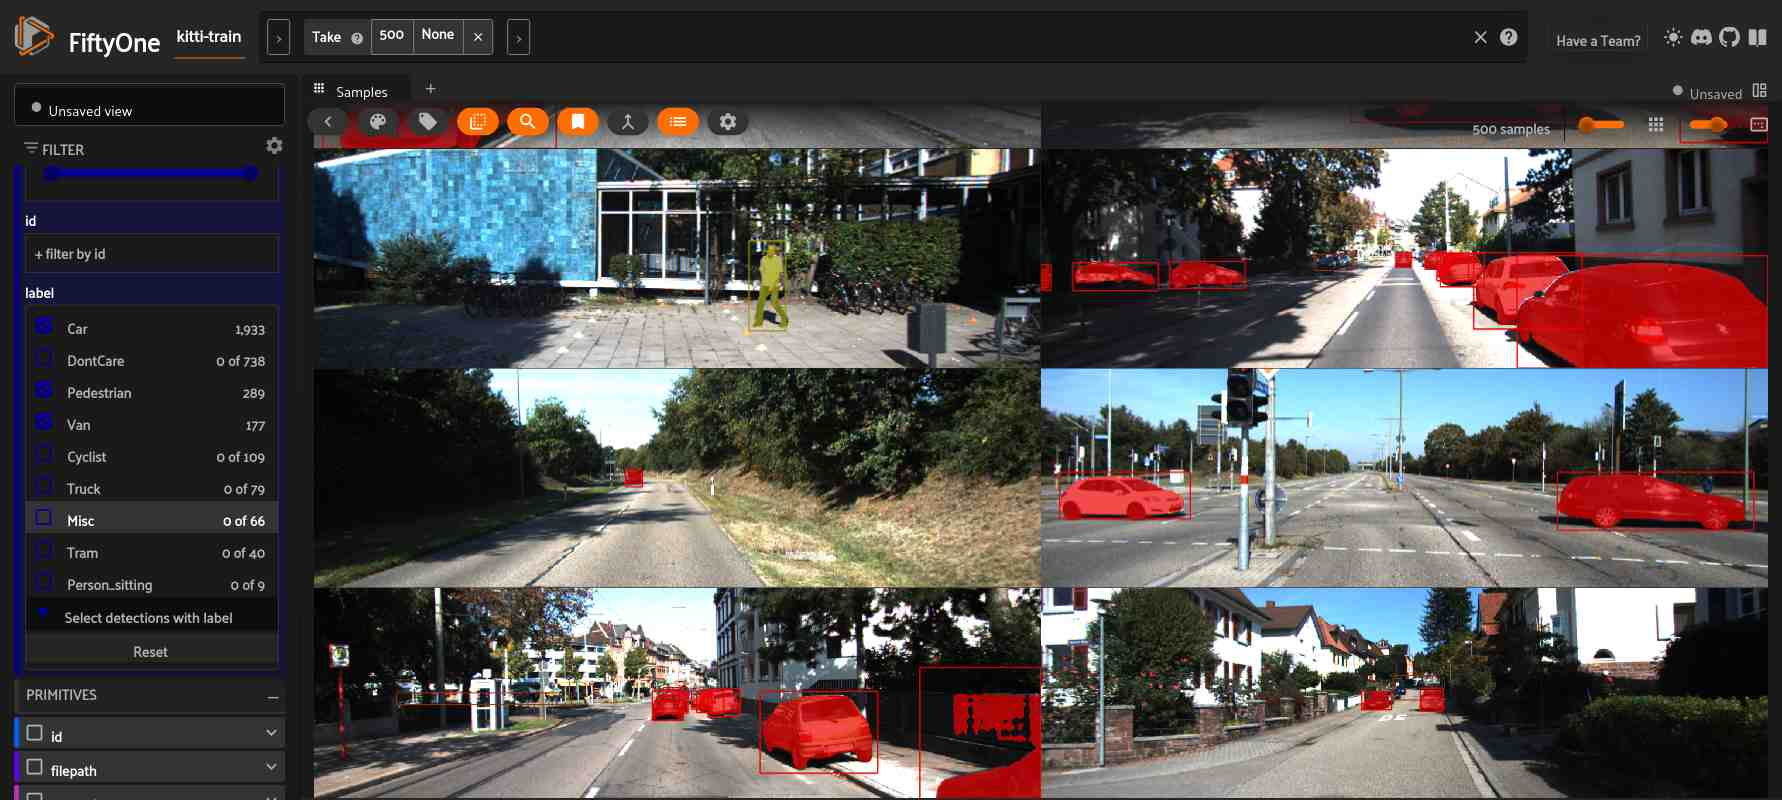

In [23]:
session.view = sub_data

In [24]:
session.freeze()

### 2. Instance Segmentation 

Instance segmentation goes beyond classification to differentiate between individual objects. Here, each instance object gets a color.


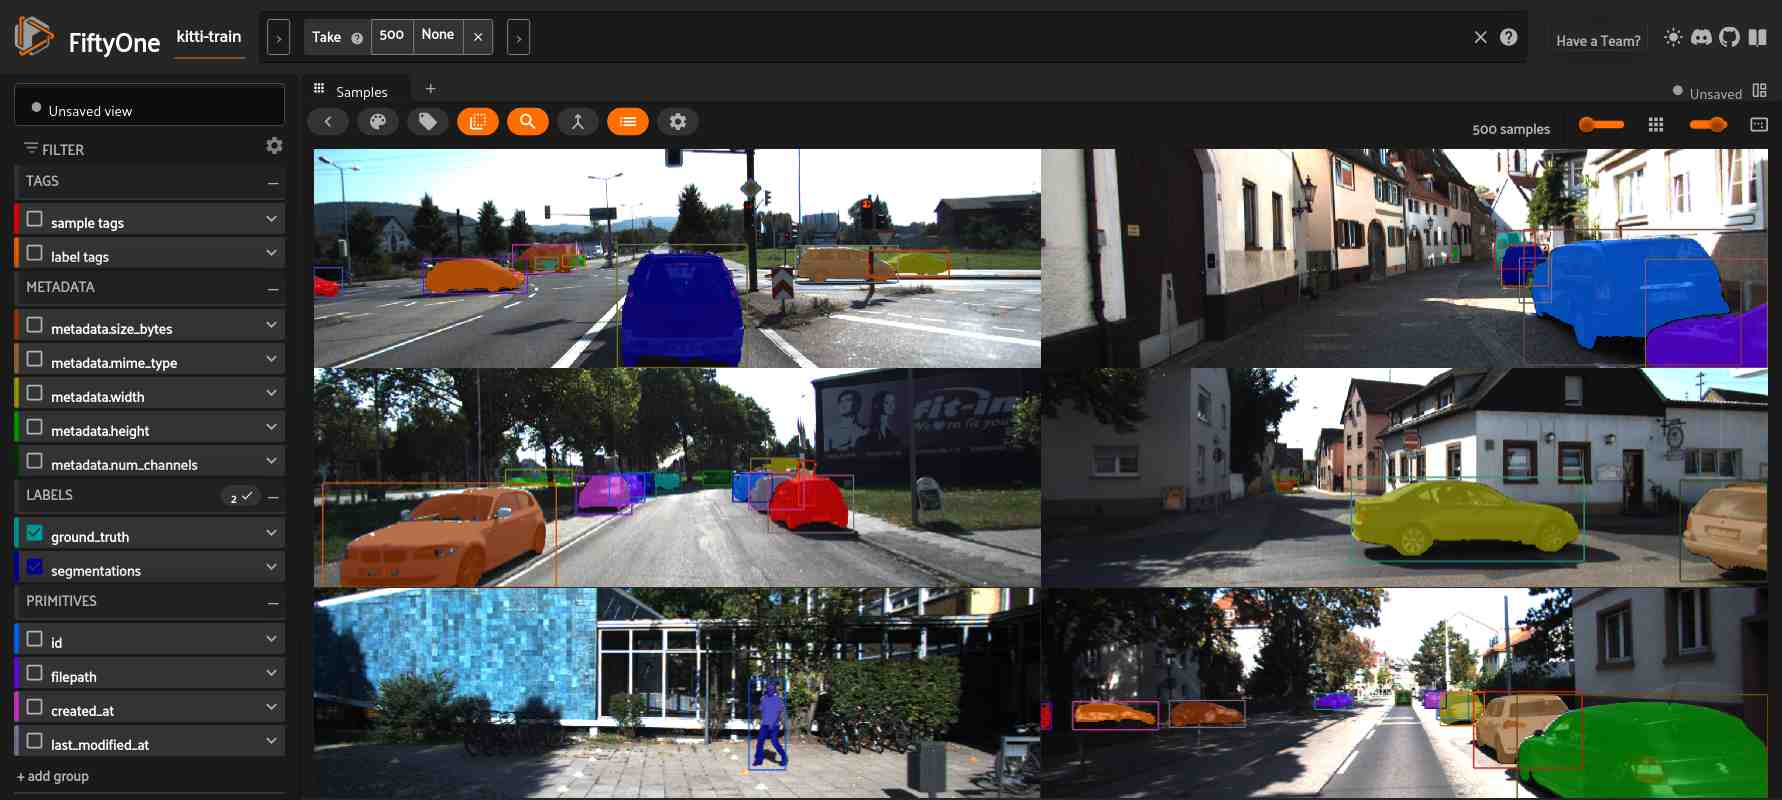

In [40]:
session = fo.launch_app(sub_data)

In [26]:
session.freeze()

## **Filtering Predictions**

Isolate images with at least ten segmented objects detected above 80% confidence.

In [41]:
view = sub_data.filter_labels(
    "segmentations",
    (F("confidence") > 0.8)
).match(
    F("segmentations.detections").length() > 10
)
view

Dataset:     kitti-train
Media type:  image
Num samples: 20
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=500, seed=None)
    2. FilterLabels(field='segmentations', filter={'$gt': ['$$this.confidence', 0.8]}, only_matches=True, trajectories=False)
    3. Match(filter={'$expr': {'$gt': [...]}})


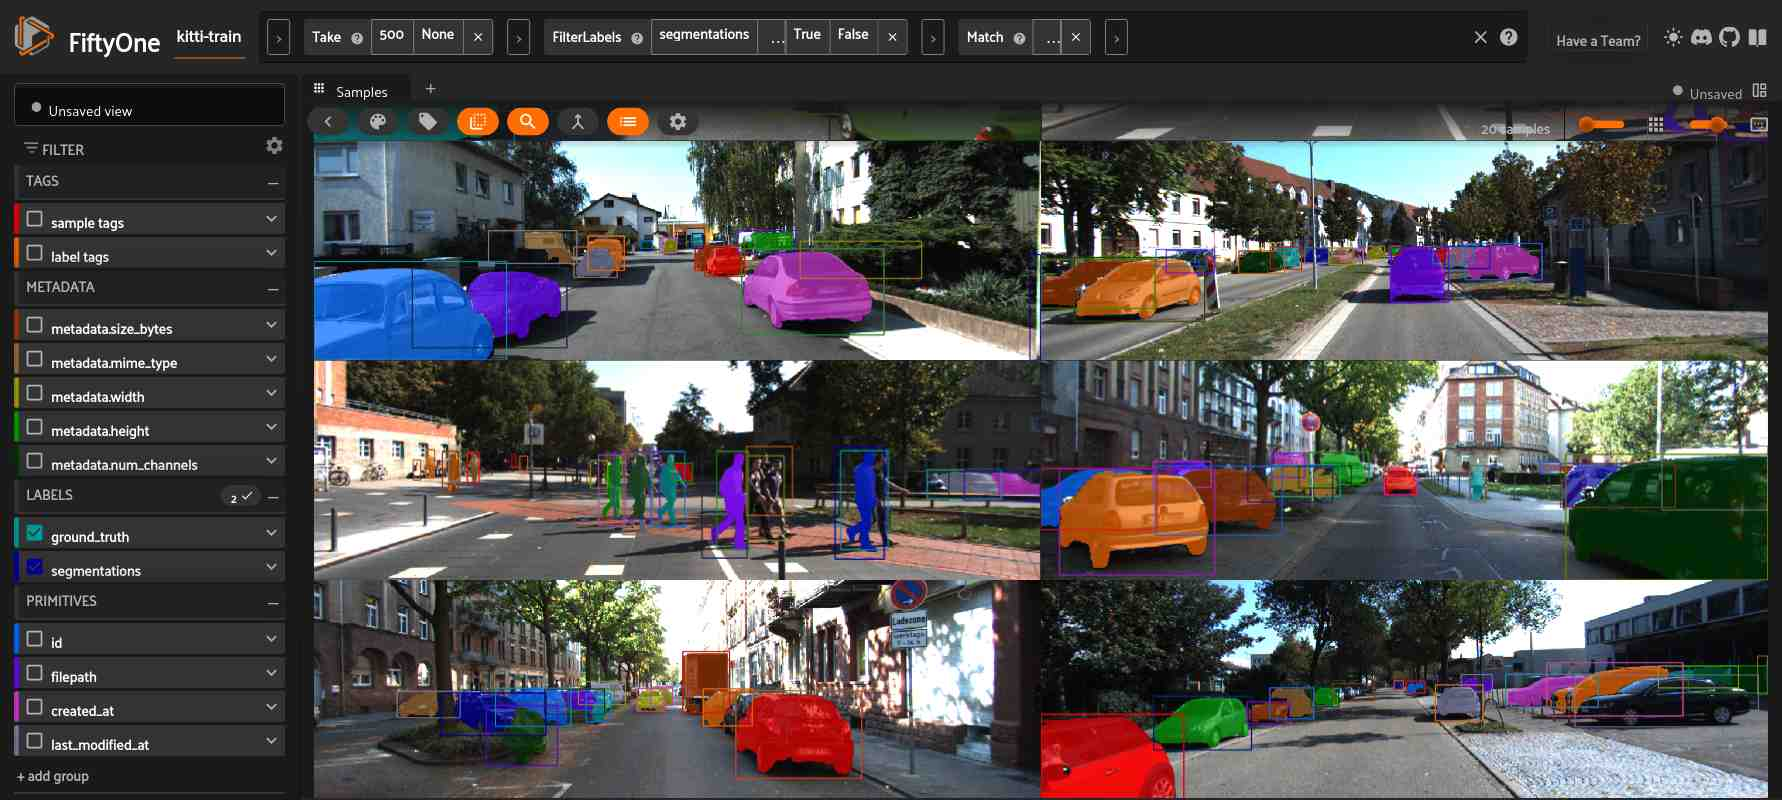

In [42]:
session.view = view

In [43]:
session.freeze()

## **Quantifying Object Areas**

Comparing the Manhattan distance between bounding boxes and filtering objects based on thresholds (e.g., selecting only those with a distance greater than 1) offers a unique perspective on occupied versus free space. For instance, this approach highlights clear roads while isolating parked cars on the side—making it invaluable for urban planning or autonomous driving scenarios.

In [2]:
# # Bboxes are in [top-left-x, top-left-y, width, height] format
# manhattan_dist = F("bounding_box")[0] + F("bounding_box")[1]

# # Only contains predictions whose bounding boxes' upper left corner
# # is a Manhattan distance of at least 1 from the origin
# view = sub_data.filter_labels(
#     "segmentations",
#     manhattan_dist > 1
# )

# view


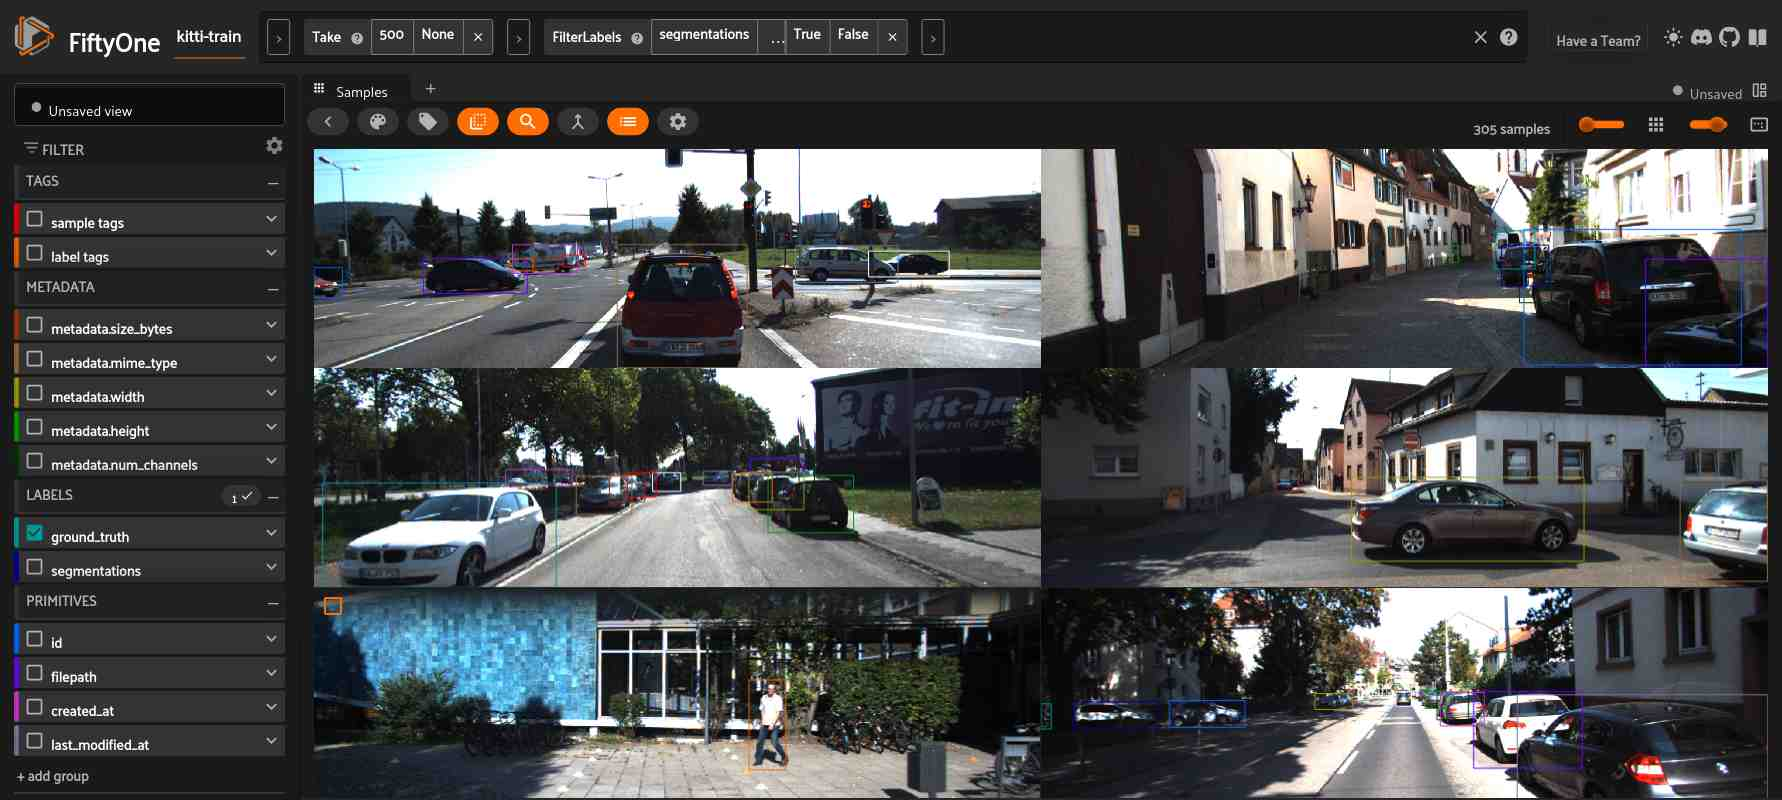

In [53]:
session.view = view

In [54]:
session.freeze()

## **Key Takeaways**

Segmentation maps transform image analysis by providing detailed, actionable insights across diverse domains. Tools like FiftyOne streamline segmentation workflows, empowering AI professionals to harness the full potential of segmentation maps for innovative solutions. In this blog, we covered:

1. **Understanding Segmentation Maps**:
    
    Segmentation maps categorize every pixel in an image, enabling a deeper understanding of scenes. From semantic segmentation for class-level understanding to instance segmentation for pinpointing individual objects, they form the backbone of modern image analysis techniques.
    
2. **Leverage FiftyOne for Visualization and Insights**:
    
    FiftyOne’s powerful tools simplify the visualization of segmentation maps, allowing AI builders to overlay predictions on images, explore dataset patterns, and gain actionable insights with intuitive filtering and detailed inspection.
    
3. **Generating High-Quality Segmentation Maps**:
    
    Creating accurate segmentation maps requires precise data annotation, thoughtful augmentation strategies, and iterative refinement. FiftyOne’s features streamline this process, empowering users to achieve reliable results efficiently.